# CNN - LSTM autoencoder model for waveform extraction from O2 noise


Evaluation of CNN-LSTM denoising autoencoder model on BBH samples injected in real noise alongwith test of robustness against Gaussian and sine-Gaussian glitch injections

In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import numpy as np
#import pandas as pd

from IPython.display import display, HTML
#import tensorflow as tf
#import numpy as np
#import pandas as pd
#import random as ran
import h5py


In [261]:
#denoised_h1 = []
#pure_h1 = []
#h1_strain = []

#mass1 = []
#mass2 = []
#snr = []


# Load data

In [318]:
f1 = h5py.File('/fred/oz016/Chayan/Autoencoder_files/2_sec_files/default_BBH_2_sec_10-40_SNR-4_test.hdf', 'r')


In [319]:
strain = f1['injection_samples']['h1_strain'][()]
signal = f1['injection_parameters']['h1_signal'][()]

m1 = f1['injection_parameters']['mass1'][()]
m2 = f1['injection_parameters']['mass2'][()]
h1_snr = f1['injection_parameters']['h1_snr'][()]*f1['injection_parameters']['scale_factor'][()]


In [320]:
#strain = np.squeeze(strain)
#signal = np.squeeze(signal)


In [321]:
signal.shape

(1, 4096)

In [322]:
f1.close()


# Normalize data

In [323]:
def normalize_test(a):
    new_array = []
    for i in range(len(a)):
        dataset = a[i]
#        dataset = dataset[1536:2048]
        maximum = np.max(dataset)
        minimum = np.abs(np.min(dataset))
        for j in range(4096):
            if(dataset[j] > 0):
                dataset[j] = dataset[j]/maximum
            else:
                dataset[j] = dataset[j]/minimum
#        dataset = dataset+gauss
        new_array.append(dataset)
    return new_array

h1_test_new = normalize_test(strain)

#h1_pure_new = normalize_new(h1_pure_new)
h1_test_pure_new = normalize_test(signal)


In [324]:
h1_test_new = np.array(h1_test_new)
h1_test_pure_new = np.array(h1_test_pure_new)


In [325]:
h1_test_new = np.squeeze(h1_test_new)
h1_test_pure_new = np.squeeze(h1_test_pure_new)


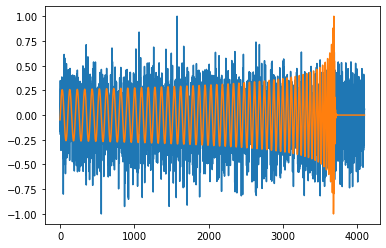

In [326]:
plt.plot(h1_test_new)
plt.plot(h1_test_pure_new)


# Reshape data into sub-sequences

In [327]:
from numpy import array
# split a univariate sequence into samples
def split_sequence(sequence_noisy,sequence_pure,n_steps):
    X, y = list(), list()
    for i in range(len(sequence_noisy)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence_noisy)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence_noisy[i:end_ix], sequence_pure[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# choose a number of time steps
n_steps = 8
X_test_noisy = []
X_test_pure = []

for i in range(1):
    X_noisy = h1_test_new[None,:][i]
    X_pure = h1_test_pure_new[None,:][i]
    X_noisy = np.pad(X_noisy, (8, 8), 'constant', constant_values=(0, 0))
    X_pure = np.pad(X_pure, (8, 8), 'constant', constant_values=(0, 0))
    # split into samples
    X, y = split_sequence(X_noisy, X_pure, n_steps)
    X_test_noisy.append(X)
    X_test_pure.append(y)
    
X_test_noisy = np.asarray(X_test_noisy)
X_test_pure = np.asarray(X_test_pure)


In [328]:
X_test_noisy = X_test_noisy[:,:,:,None]
X_test_pure = X_test_pure[:,:,None]
        
print('x_test_noisy shape:', X_test_noisy.shape)
print('x_test_pure shape:', X_test_pure.shape)

X_test_noisy = X_test_noisy.astype("float32")
X_test_pure = X_test_pure.astype("float32")


x_test_noisy shape: (1, 4104, 8, 1)
x_test_pure shape: (1, 4104, 1)


# FracTAL Tanimoto loss function

In [329]:
def fractal_tanimoto_loss(self, y_true, y_pred, depth=None, smooth=1e-6):
        """ Defining FracTAL Tanimoto loss function """
        x = y_true
        y = y_pred
        
        if depth is None:
            depth = self.depth            
        
        depth = self.depth+1
        scale = 1./len(range(depth))
    
        def inner_prod(y, x):
            prod = y*x
            prod = K.sum(prod, axis=1)
        
            return prod
    
        def tnmt_base(x, y):

            tpl  = inner_prod(y,x)
            tpp  = inner_prod(y,y)
            tll  = inner_prod(x,x)


            num = tpl + smooth
            denum = 0.0
            result = 0.0
            for d in range(depth):
                a = 2.**d
                b = -(2.*a-1.)

                denum = denum + tf.math.reciprocal( a*(tpp+tll) + b *tpl + smooth)
                
            result =  num * denum * scale
            
            return  result*scale
    
        l1 = K.mean(K.square(y_pred - y_true),axis=-1)
        result = tnmt_base(x,y)
        
        return  l1 - result
    

# Load trained model

In [279]:
#from keras.models import load_model
 
# load model
model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_2_sec_new_model.h5', custom_objects={'fractal_tanimoto_loss': fractal_tanimoto_loss})
# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 4104, 8, 32)       128       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4104, 8, 32)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4104, 4, 32)       0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 4104, 4, 16)       1552      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 4104, 4, 16)       0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 4104, 2, 16)       0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 4104, 2, 8)        3

# Obtain predictions on test data

In [330]:
decoded_signals = model.predict(X_test_noisy, batch_size=2000)

#score = model.evaluate(X_test_noisy, X_test_pure, verbose=1, batch_size=2000)

#print('\nAccuracy on test data: %0.2f' % score[1])
#print('\nLoss on test data: %0.2f' % score[0])


# Plot test sample

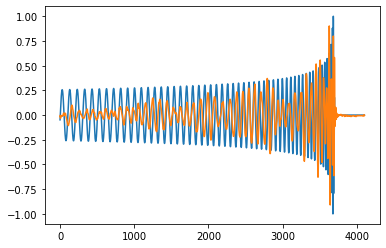

In [331]:
plt.plot(X_test_pure[0])
plt.plot(decoded_signals[0])


# Overlap calculation

In [3]:
def Overlap_calc(hp,sp,psd):
    f_low = 18
    m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    o = overlap(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    return m


In [333]:
from pycbc.filter import match, overlap
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types.timeseries import TimeSeries

time_buffer = 4

f_low = 18
sample_rate = 2048

# Length of corresponding time series and frequency series
tlen = sample_rate * time_buffer
flen = tlen // 2 + 1

delta_f = 1.0 / time_buffer
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

X_test_pure = np.squeeze(X_test_pure)
decoded_signals = np.squeeze(decoded_signals)

X_test_pure = X_test_pure.tolist()
decoded_signals = decoded_signals.tolist()

X_test_pure_ts = TimeSeries(X_test_pure, delta_t = 1.0/2048)
decoded_signals_ts = TimeSeries(decoded_signals, delta_t = 1.0/2048)

X_test_pure_ts.resize(tlen)
decoded_signals_ts.resize(tlen)

m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)

m


0.3248304805557647

NameError: name 'm' is not defined

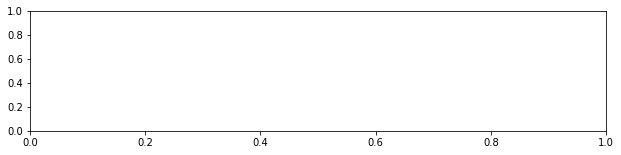

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
time = np.linspace(-1.8, 0.2, 4096)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

signal_axes = fig.add_subplot(211)
signal_axes.set_title('Mass1 = {m1}, Mass2 = {m2}, S/N = {h1_snr}, Overlap = {m}'.format(m1=np.round(m1[0],2), m2=np.round(m2[0],2), h1_snr=np.round(h1_snr[0],2), m=np.round(m,2)))
signal_axes.plot(time,X_test_pure[0:4096], linewidth=1.2, label ='Pure Hanford signal')
signal_axes.plot(time,decoded_signals[0:4096], linewidth=1.2, label ='Denoised Hanford signal')
signal_axes.set_ylabel('Rescaled Amplitudes')
signal_axes.legend()

zoomed_axes = fig.add_subplot(212)
zoomed_axes.set_title('Zoomed')
#zoomed_axes.set_autoscaley_on(False)
zoomed_axes.plot(time[3200:4096], X_test_pure[3200:4096], linewidth=1.2)
zoomed_axes.plot(time[3200:4096], decoded_signals[3200:4096], linewidth=1.2)
zoomed_axes.set_ylabel('Rescaled Amplitudes')
zoomed_axes.set_xlabel('Time from merger at (in seconds)')

plt.savefig('2_sec_plots/New_plots_1/Plot_m1-'+str(np.int(m1[0]))+'_m2-'+str(np.int(m2[0]))+'_snr-'+str(np.int(h1_snr[0]))+'.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


In [516]:
h1_denoised_ = np.squeeze(decoded_signals[0][0:4096])
h1_pure_ = np.squeeze(X_test_pure[0][0:4096])


In [517]:
denoised_h1.append(h1_denoised_)
pure_h1.append(h1_pure_)
h1_strain.append(h1_test_new)

mass1.append(m1)
mass2.append(m2)
snr.append(h1_snr)


In [499]:
#denoised_h1 = np.array(denoised_h1)


In [518]:
denoised_h1 = np.array(denoised_h1)

In [519]:
pure_h1 = np.array(pure_h1)
h1_strain = np.array(h1_strain)
mass1 = np.array(mass1)
mass2 = np.array(mass2)
snr = np.array(snr)


In [520]:
f1 = h5py.File('./2_sec_plots/New_plots/results_1.hdf', 'w')
f1.create_dataset('strain_signal', data=h1_strain)
f1.create_dataset('pure_signal', data=pure_h1)
f1.create_dataset('denoised_signal', data=denoised_h1)
f1.create_dataset('mass1', data=mass1)
f1.create_dataset('mass2', data=mass2)
f1.create_dataset('snr', data=snr)


<HDF5 dataset "snr": shape (15, 1), type "<f8">

In [77]:
f1 = h5py.File('/fred/oz016/Chayan/GW-Denoiser/evaluation/results_IMBH.hdf', 'r')


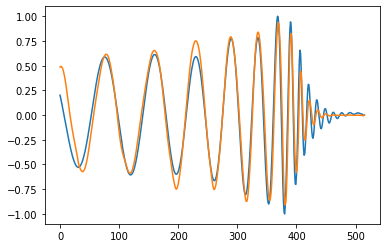

In [78]:
plt.plot(f1['pure_signals'][0])
plt.plot(f1['denoised_signals'][0])


In [79]:
decoded_signals = f1['denoised_signals'][0].astype(np.float64)
pure_signals = f1['pure_signals'][0].astype(np.float64)


In [2]:
f1 = h5py.File("/fred/oz016/Chayan/BBH_sample_files/default_IMBH_precessing_test.hdf", "r")

strain = f1['injection_samples']['h1_strain'][()]
signal = f1['injection_parameters']['h1_signal'][()]

m1 = f1['injection_parameters']['mass1'][()]
m2 = f1['injection_parameters']['mass2'][()]
h1_snr = f1['injection_parameters']['l1_snr'][()]*f1['injection_parameters']['scale_factor'][()]


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/fred/oz016/Chayan/BBH_sample_files/default_IMBH_precessing_test.hdf', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [82]:
from pycbc.filter import match, overlap
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types.timeseries import TimeSeries

time_buffer = 4

f_low = 18
sample_rate = 2048

# Length of corresponding time series and frequency series
tlen = sample_rate * time_buffer
flen = tlen // 2 + 1

delta_f = 1.0 / time_buffer
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

#X_test_pure = X_test_pure.tolist()
#decoded_signals = decoded_signals.tolist()

X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/2048)
decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/2048)

X_test_pure_ts.resize(tlen)
decoded_signals_ts.resize(tlen)

m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)

m


0.9768559458607569

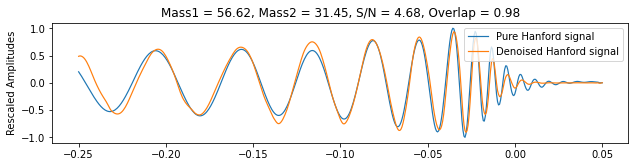

In [87]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
time = np.linspace(-0.25, 0.05, 516)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

signal_axes = fig.add_subplot(211)
signal_axes.set_title('Mass1 = {m1}, Mass2 = {m2}, S/N = {h1_snr}, Overlap = {m}'.format(m1=np.round(m1[0],2), m2=np.round(m2[0],2), h1_snr=np.round(h1_snr[0],2), m=np.round(m,2)))
signal_axes.plot(time,pure_signals.squeeze(), linewidth=1.2, label ='Pure Hanford signal')
signal_axes.plot(time,decoded_signals.squeeze(), linewidth=1.2, label ='Denoised Hanford signal')
signal_axes.set_ylabel('Rescaled Amplitudes')
signal_axes.legend()

plt.savefig('IMBH_test/Unwhitened_waveforms_Gaussian/Plot_m1-'+str(int(m1[0]))+'_m2-'+str(int(m2[0]))+'_snr-'+str(int(h1_snr[0]))+'.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


In [2]:
def Overlap_calc(hp,sp,psd):
    f_low = 18
    m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    o = overlap(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    return m


In [3]:
from pycbc.filter import match, overlap
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types.timeseries import TimeSeries
import matplotlib.pyplot as plt

def plot_reconstructed(decoded_signals, pure_signals, m1, m2, snr):
    
    time_buffer = 4
    length_signal = len(decoded_signals)

    f_low = 18
    sample_rate = 2048

    # Length of corresponding time series and frequency series
    tlen = sample_rate * time_buffer
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    X_test_pure_ts = TimeSeries(pure_signals.squeeze(), delta_t = 1.0/2048)
    decoded_signals_ts = TimeSeries(decoded_signals.squeeze(), delta_t = 1.0/2048)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)

    if(X_test_pure_ts.max() != 0.0):
        m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    else:
        m = 1
    
    fig = plt.figure(figsize=(10,5))

    time = np.linspace(-0.25, 0.05, length_signal)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    signal_axes = fig.add_subplot(211)
    signal_axes.set_ylim(-1.0, 1.0)
    signal_axes.set_title('Mass1 = {m1}, Mass2 = {m2}, S/N = {snr}, Overlap = {m}'.format(m1=np.round(m1,2), m2=np.round(m2,2), snr=np.round(snr,2), m=np.round(m,2)))
    signal_axes.plot(time,pure_signals.squeeze(), linewidth=1.2, label ='Pure Hanford signal')
    signal_axes.plot(time,decoded_signals.squeeze(), linewidth=1.2, label ='Denoised Hanford signal')
    signal_axes.set_ylabel('Rescaled Amplitudes')
    signal_axes.legend()

    plt.savefig('IMBH_test/IMRPhenomXPHM_O3b_signal+noise/Plot_m1-'+str(int(m1))+'_m2-'+str(int(m2))+'_snr-'+str(int(snr))+'.png', bbox_inches='tight', facecolor='w', transparent=False, dpi=200)


<ipython-input-3-796cfc099e86>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,5))


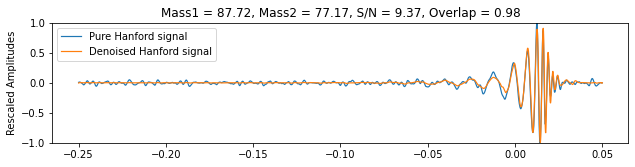

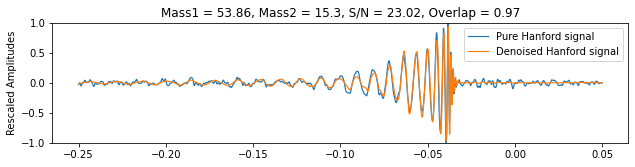

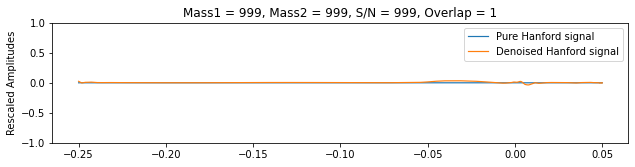

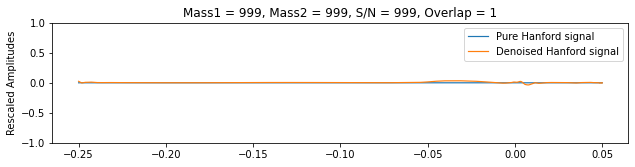

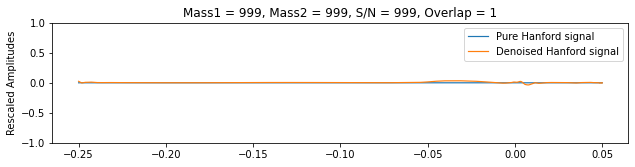

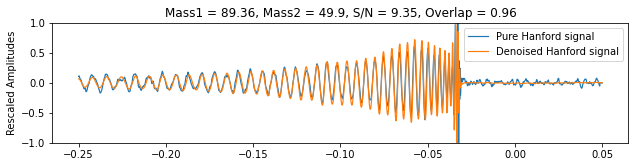

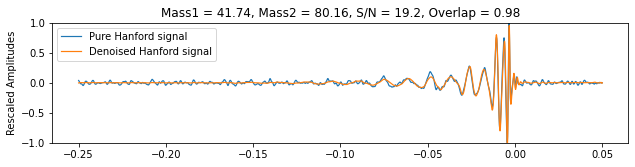

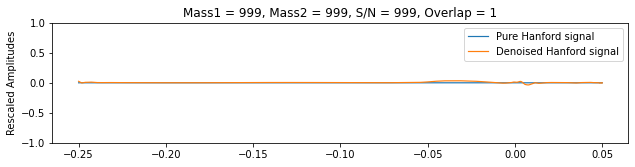

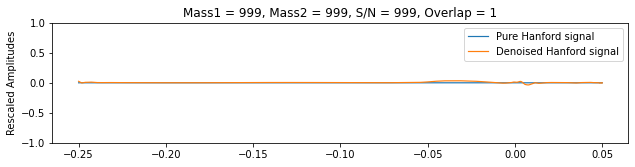

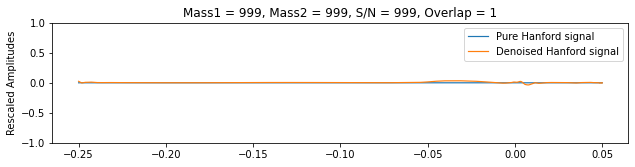

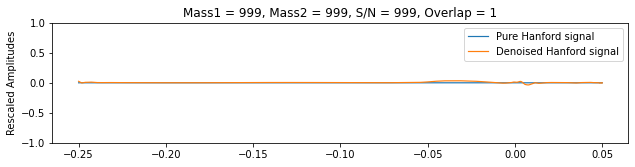

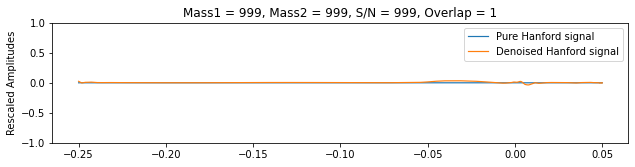

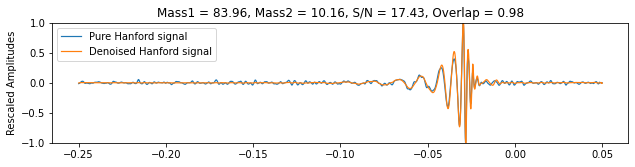

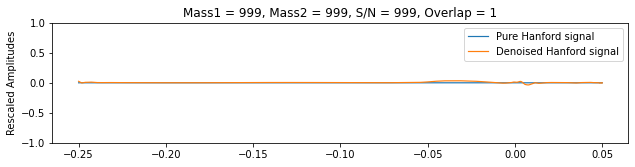

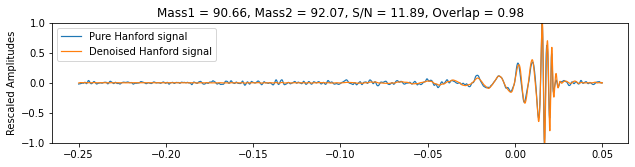

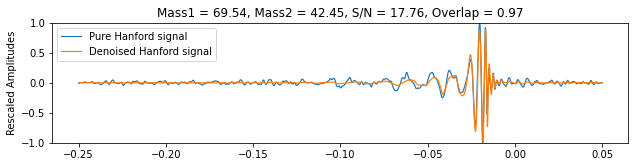

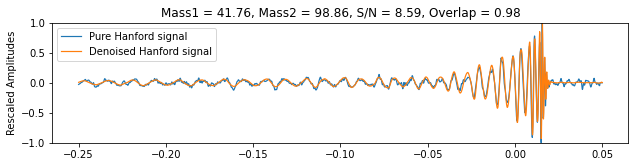

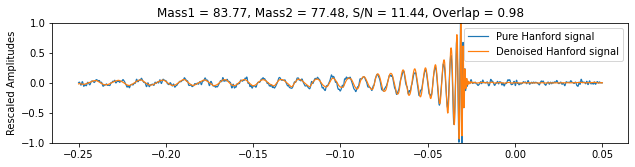

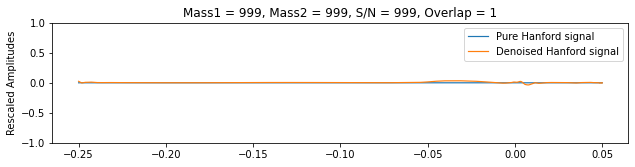

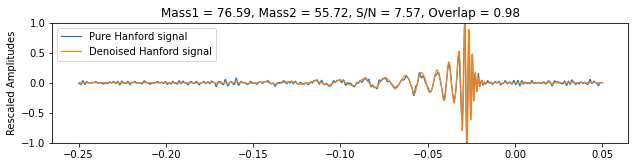

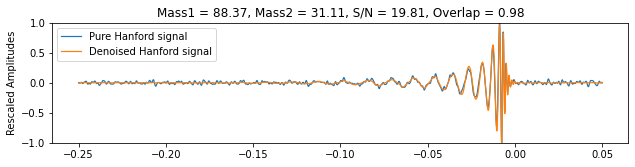

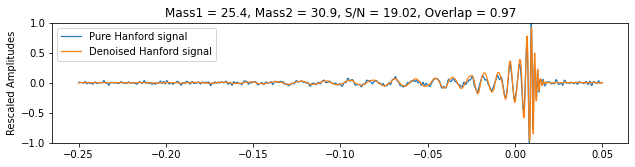

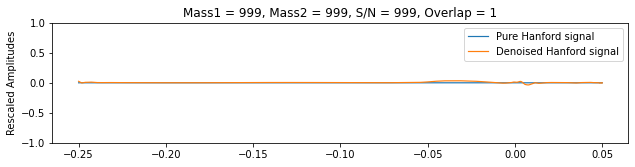

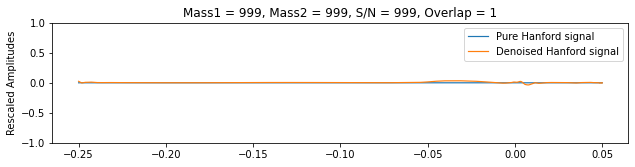

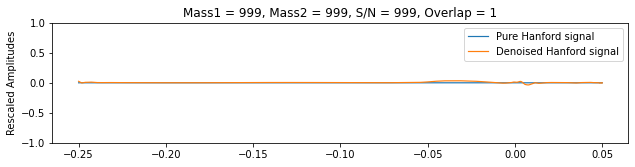

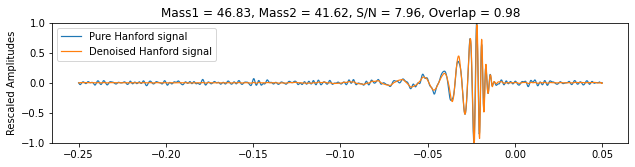

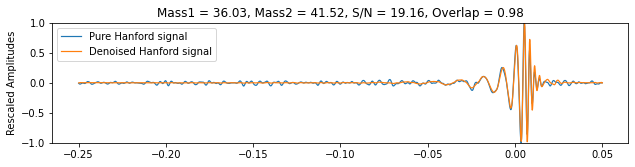

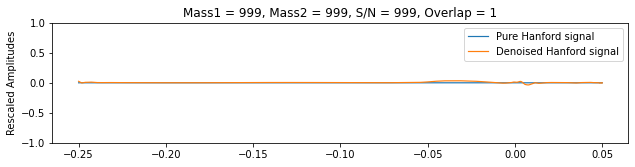

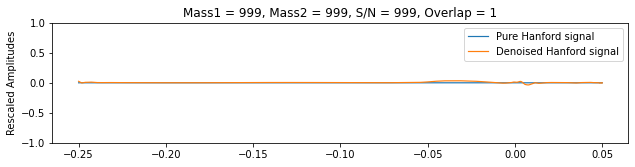

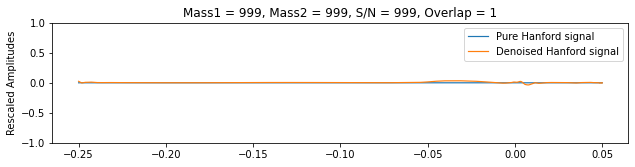

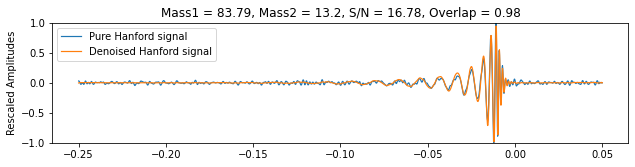

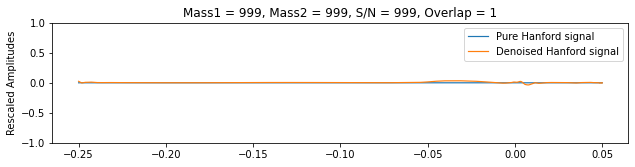

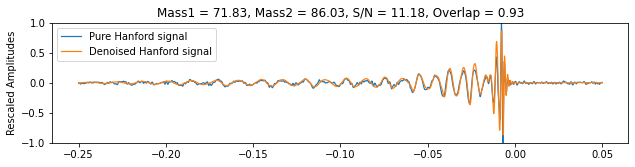

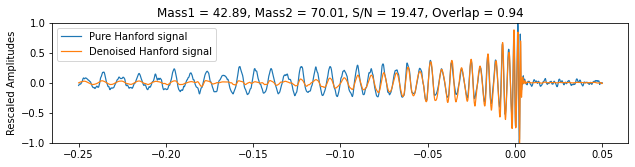

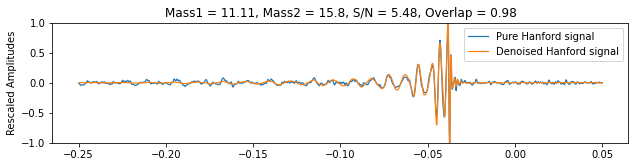

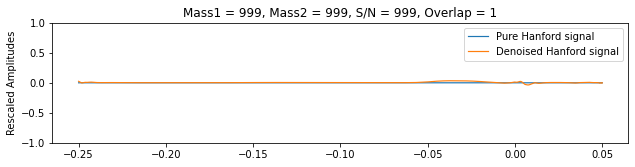

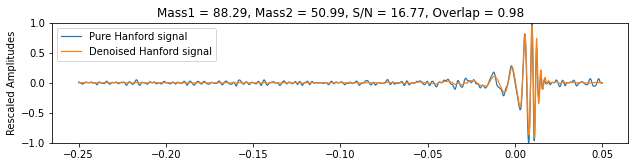

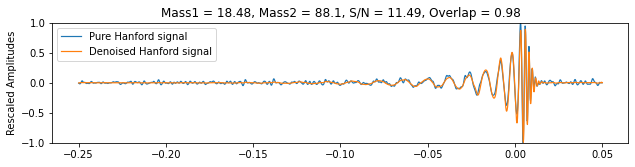

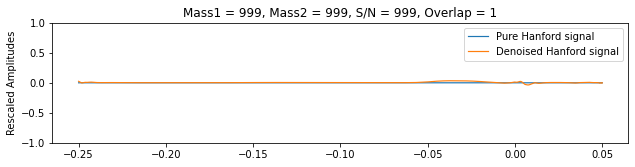

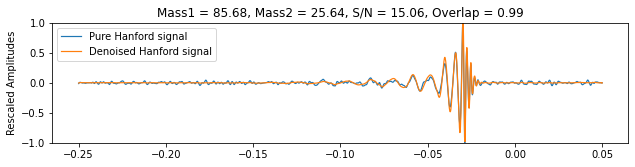

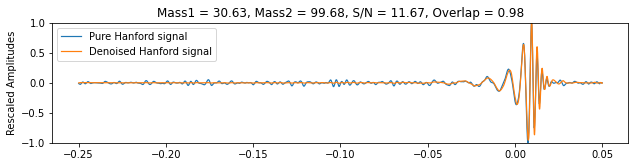

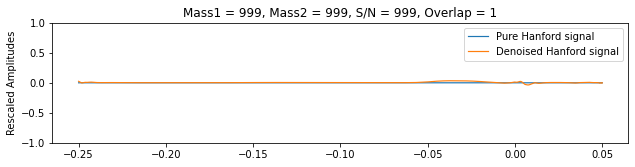

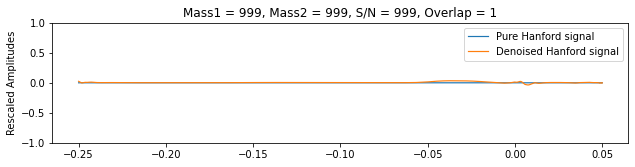

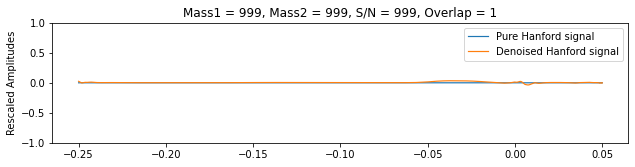

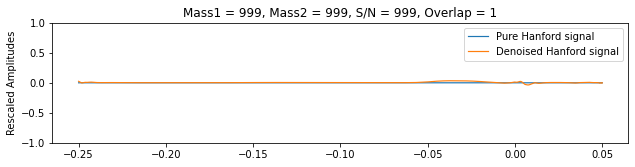

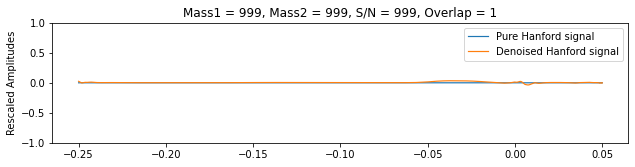

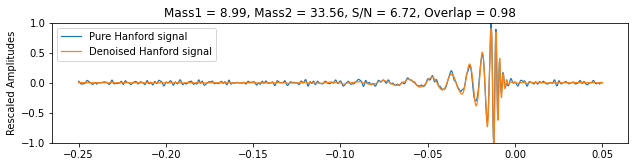

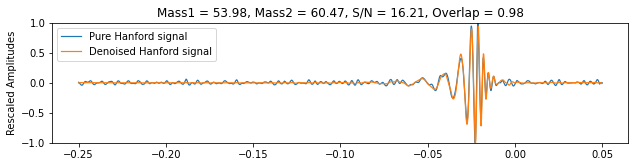

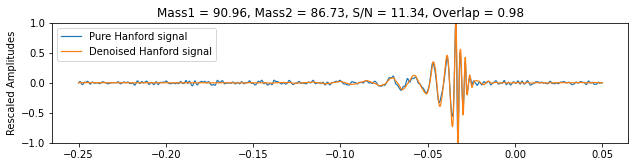

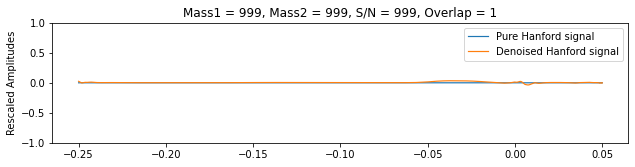

In [4]:
f1 = h5py.File('/fred/oz016/Chayan/GW-Denoiser/evaluation/results_IMBH_IMRPhenomXPHM_10_timesteps_O3b_signal_noise_SNR-8to30.hdf', 'r')
f2 = h5py.File("/fred/oz016/Chayan/BBH_sample_files/O3b_IMBH_test_IMRPhenomXPHM_signal_noise_SNR-8to30.hdf", "r")

noise_index = [2,3,4,7,8,9,10,11,13,18,22,23,24,27,28,29,31,35,38,41,42,43,44,45,49]
signal_index = range(25)
j = -1
   
for i in range(50):
    decoded_signals = f1['denoised_signals'][i].astype(np.float64)
    pure_signals = f1['pure_signals'][i].astype(np.float64)
    
    if i in noise_index:
        m1 = 999
        m2 = 999
        snr = 999
    else:
        j = j+1
        m1 = f2['injection_parameters']['mass1'][j]
        m2 = f2['injection_parameters']['mass2'][j]
        snr = f2['injection_parameters']['l1_snr'][j]*f2['injection_parameters']['scale_factor'][j]

    plot_reconstructed(decoded_signals, pure_signals, m1, m2, snr)
    

<ipython-input-6-3445b7de4074>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,5))


IndexError: Index (25) out of range for (0-24)

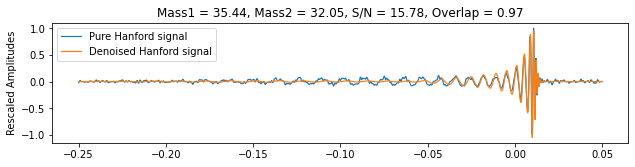

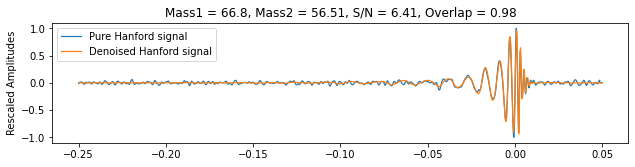

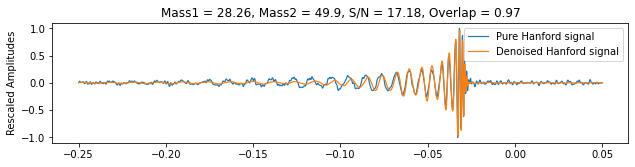

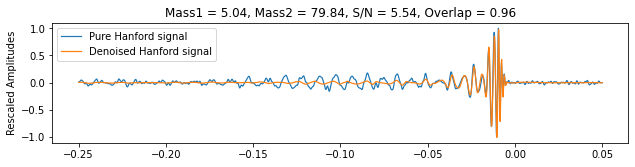

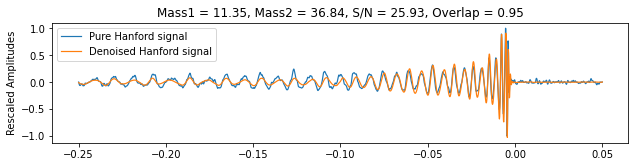

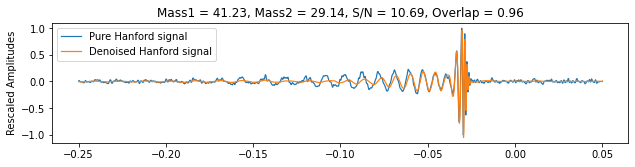

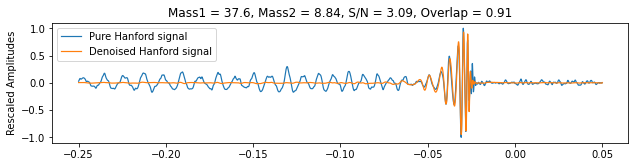

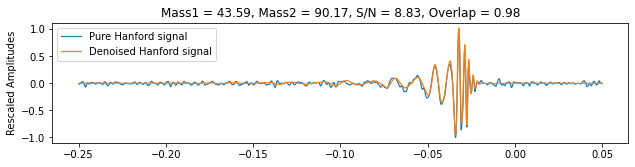

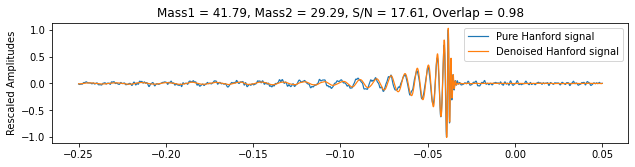

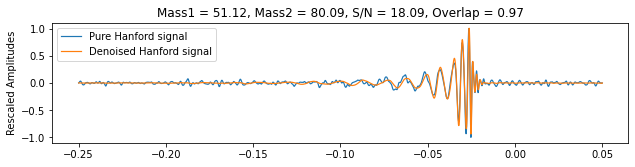

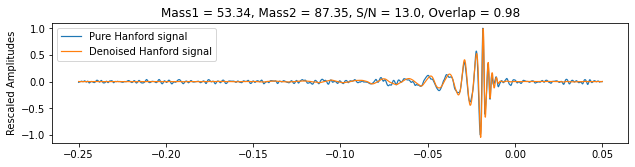

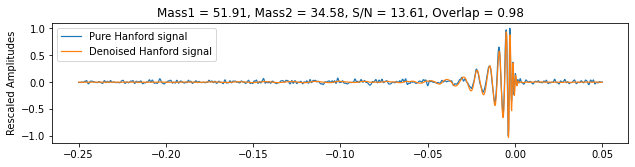

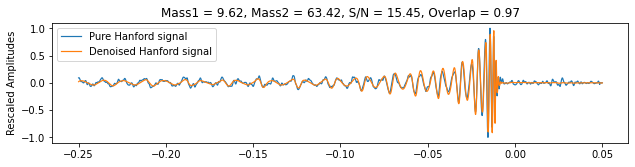

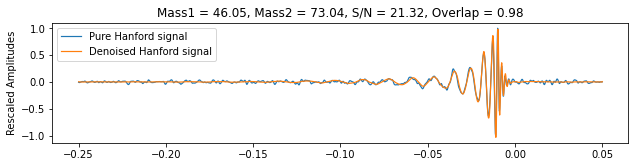

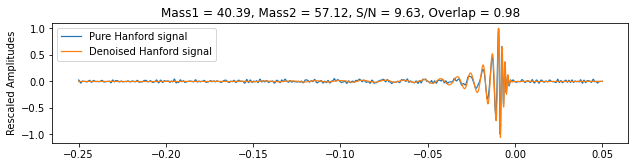

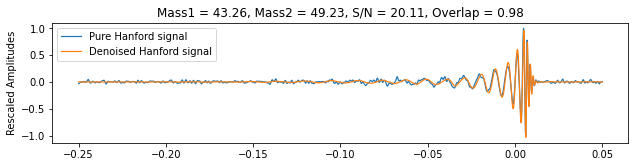

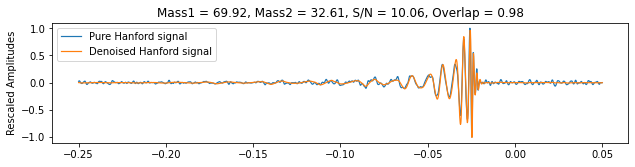

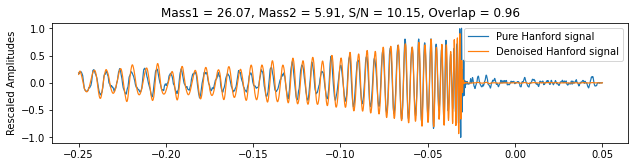

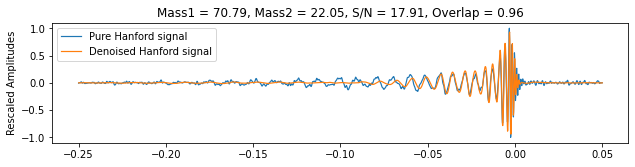

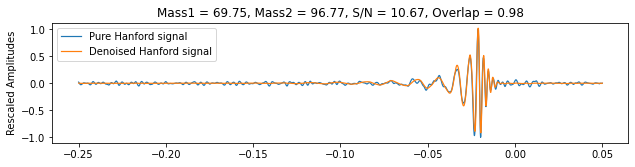

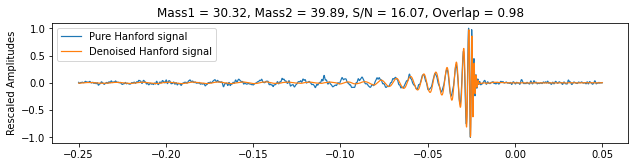

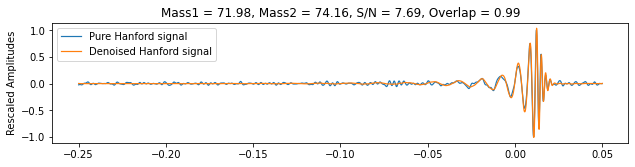

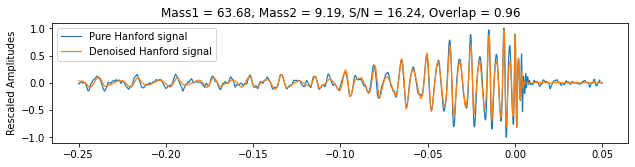

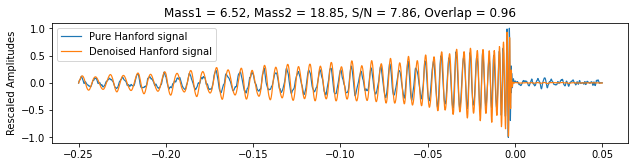

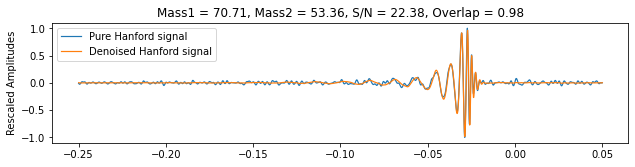

In [8]:
f1 = h5py.File('/fred/oz016/Chayan/GW-Denoiser/evaluation/results_IMBH_IMRPhenomXPHM_10_timesteps_O3b_noise.hdf', 'r')
f2 = h5py.File("/fred/oz016/Chayan/BBH_sample_files/O3b_IMBH_test_IMRPhenomXPHM.hdf", "r")
    
for i in range(25):
    decoded_signals = f1['denoised_signals'][i].astype(np.float64)
    pure_signals = f1['pure_signals'][i].astype(np.float64)

    m1 = f2['injection_parameters']['mass1'][i]
    m2 = f2['injection_parameters']['mass2'][i]
    snr = f2['injection_parameters']['l1_snr'][i]*f2['injection_parameters']['scale_factor'][i]

    plot_reconstructed(decoded_signals, pure_signals, m1, m2, snr)
    

<ipython-input-3-d4ab2bc3f7c5>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,5))


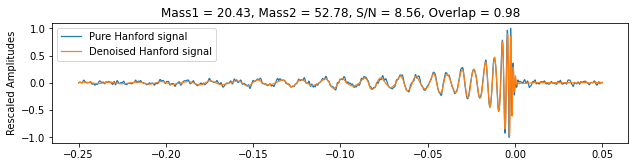

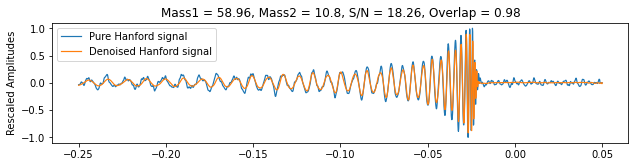

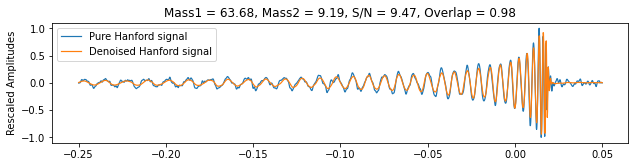

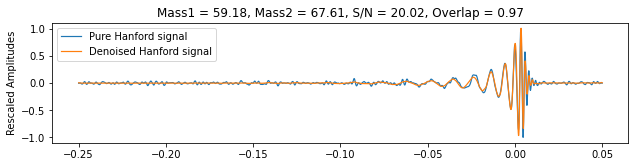

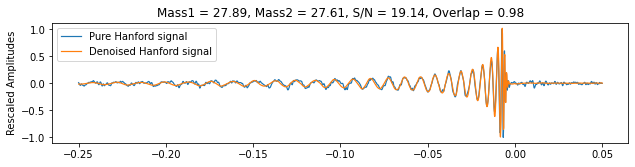

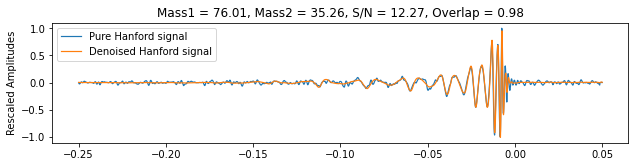

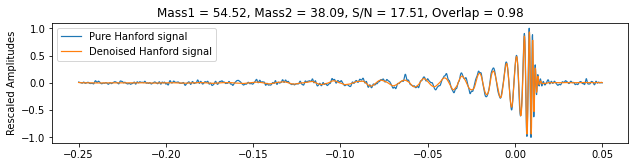

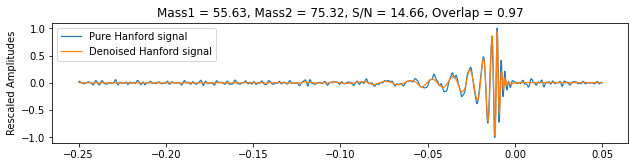

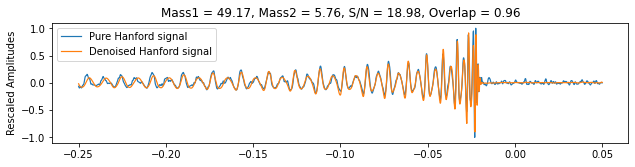

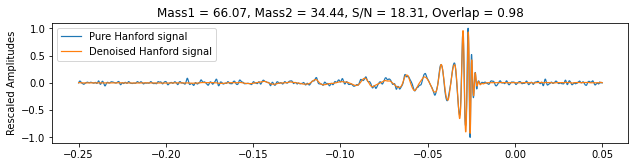

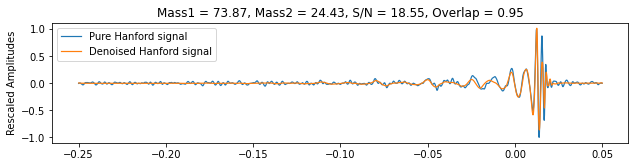

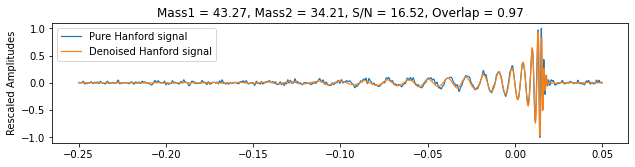

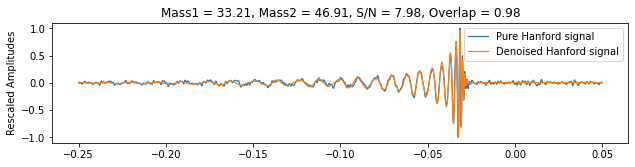

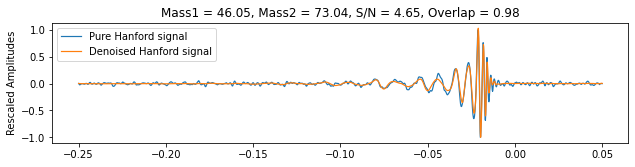

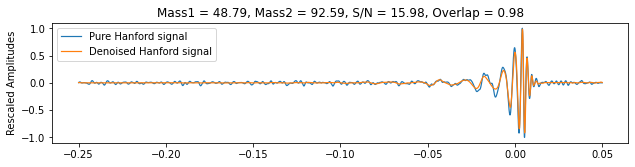

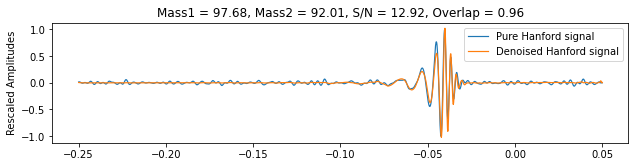

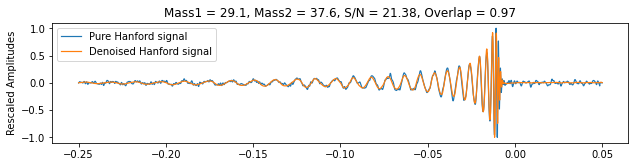

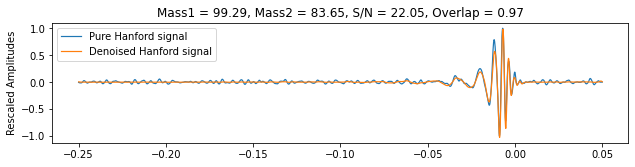

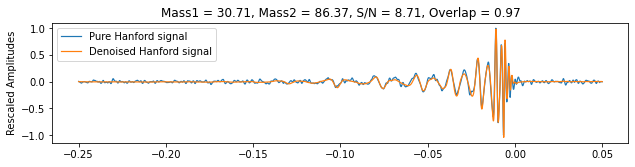

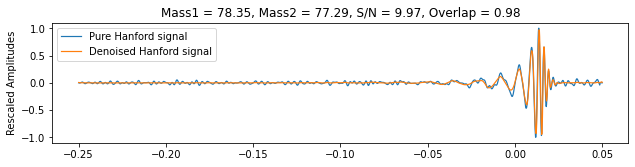

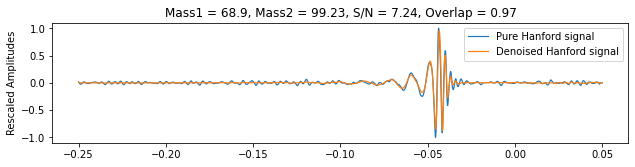

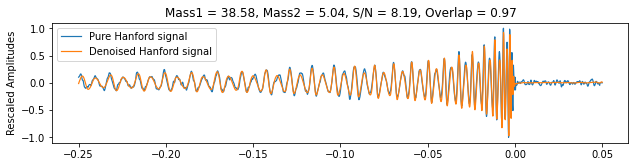

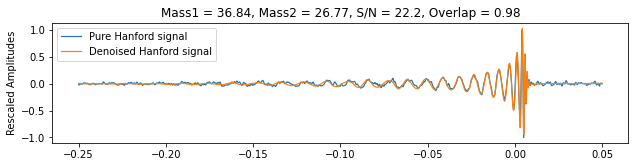

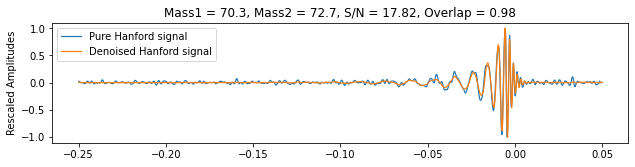

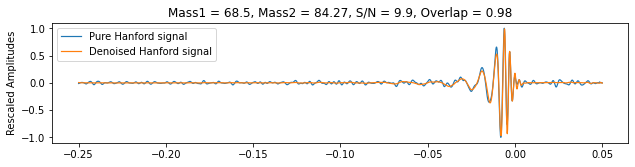

In [4]:
f1 = h5py.File('/fred/oz016/Chayan/GW-Denoiser/evaluation/results_IMBH_HM_10_timesteps_O3b_noise.hdf', 'r')
f2 = h5py.File("/fred/oz016/Chayan/BBH_sample_files/O3b_IMBH_test_HM.hdf", "r")
    
for i in range(25):
    decoded_signals = f1['denoised_signals'][i].astype(np.float64)
    pure_signals = f1['pure_signals'][i].astype(np.float64)

    m1 = f2['injection_parameters']['mass1'][i]
    m2 = f2['injection_parameters']['mass2'][i]
    snr = f2['injection_parameters']['l1_snr'][i]*f2['injection_parameters']['scale_factor'][i]

    plot_reconstructed(decoded_signals, pure_signals, m1, m2, snr)
    

<ipython-input-3-a8f2c0f5b3ad>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,5))


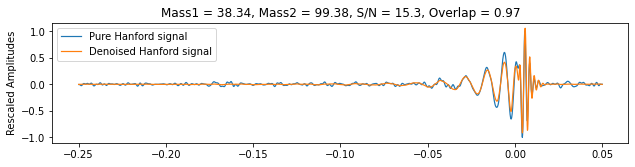

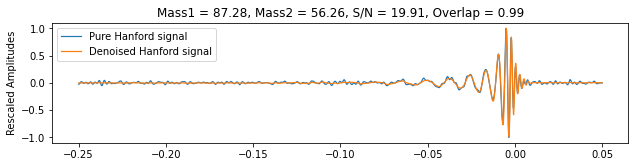

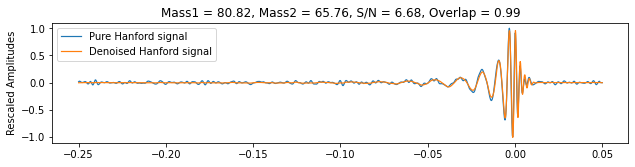

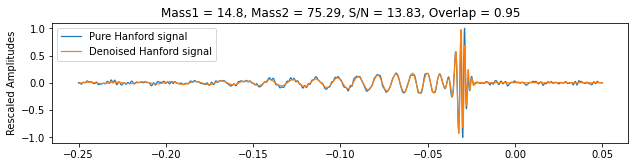

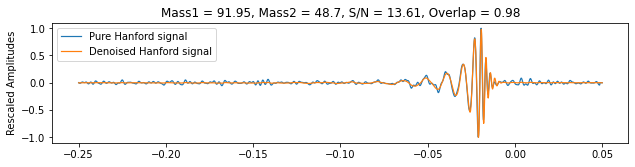

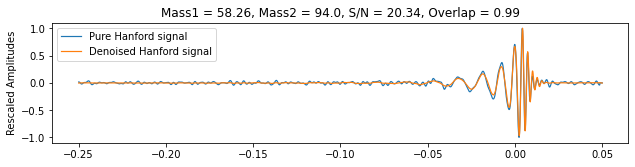

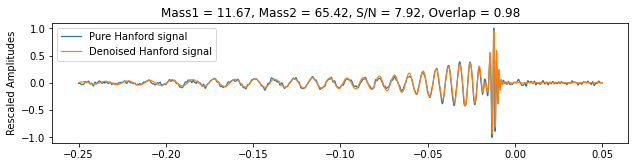

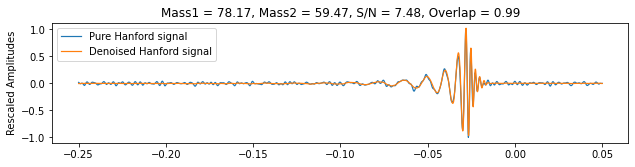

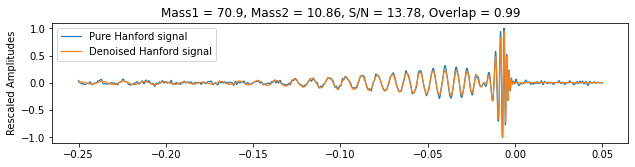

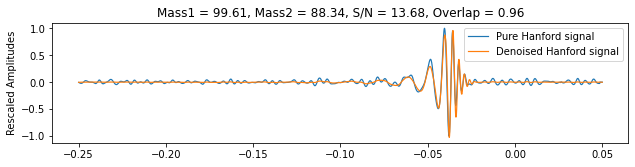

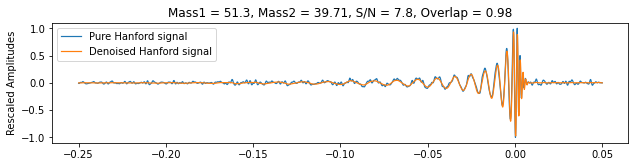

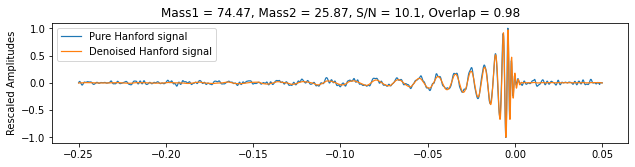

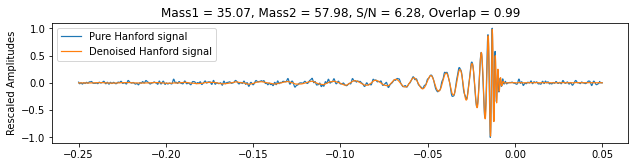

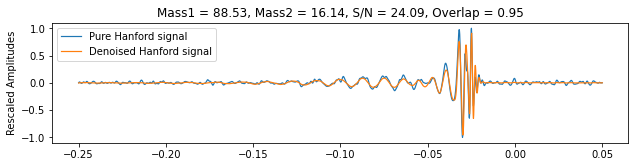

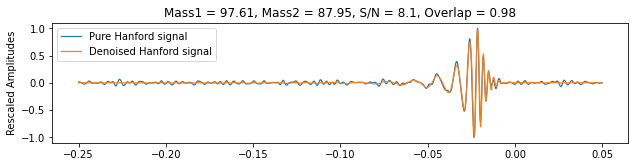

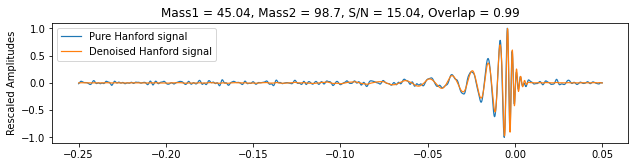

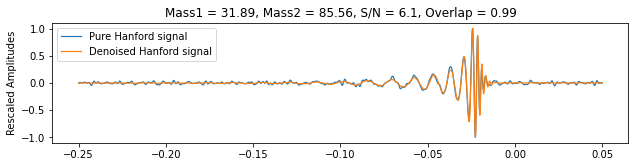

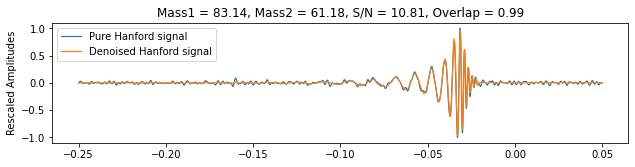

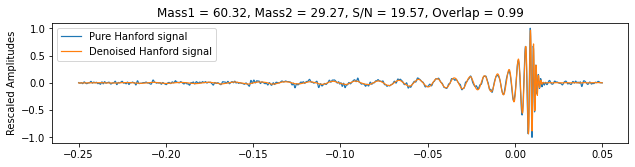

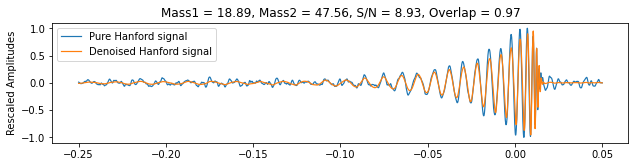

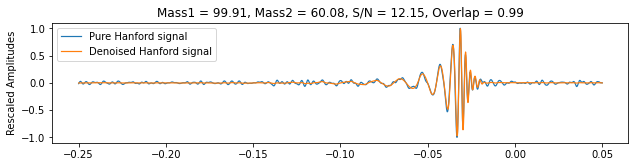

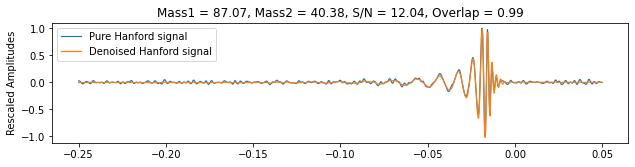

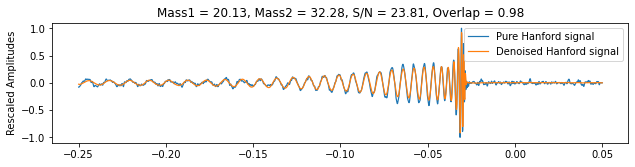

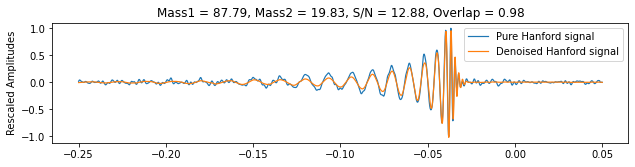

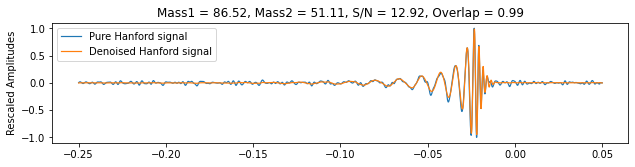

In [4]:
f1 = h5py.File('/fred/oz016/Chayan/GW-Denoiser/evaluation/results_IMBH_precessing_10_timesteps_O3b_noise.hdf', 'r')
f2 = h5py.File("/fred/oz016/Chayan/BBH_sample_files/O3b_IMBH_test_precession.hdf", "r")
    
for i in range(25):
    decoded_signals = f1['denoised_signals'][i].astype(np.float64)
    pure_signals = f1['pure_signals'][i].astype(np.float64)

    m1 = f2['injection_parameters']['mass1'][i]
    m2 = f2['injection_parameters']['mass2'][i]
    snr = f2['injection_parameters']['l1_snr'][i]*f2['injection_parameters']['scale_factor'][i]

    plot_reconstructed(decoded_signals, pure_signals, m1, m2, snr)
    

<ipython-input-3-b0e826a275db>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,5))


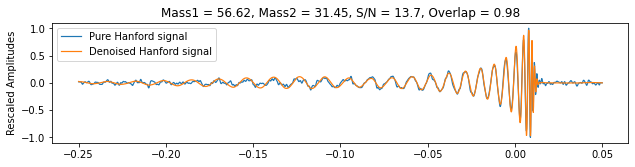

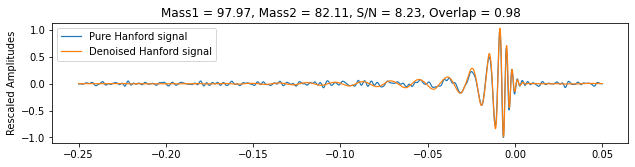

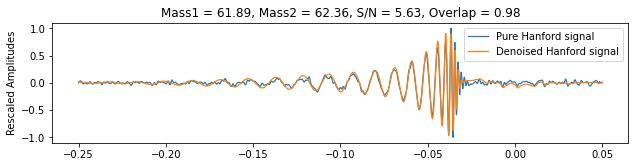

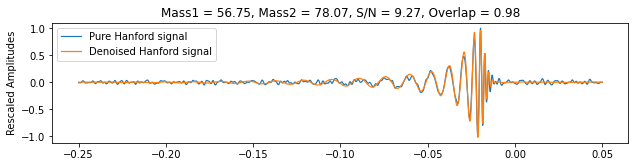

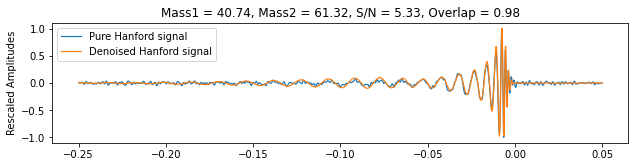

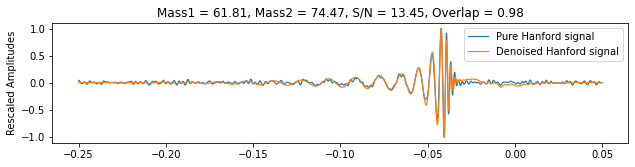

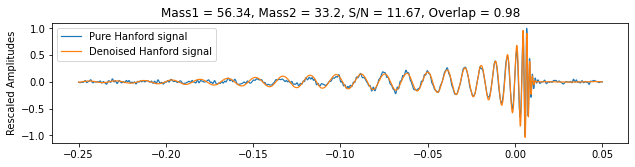

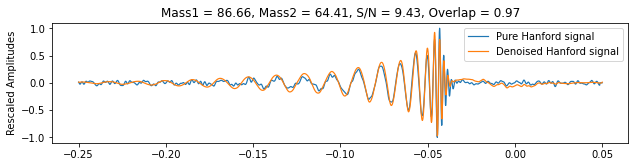

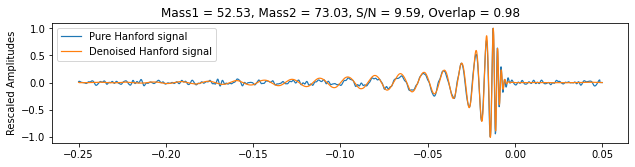

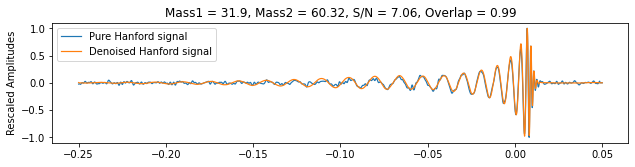

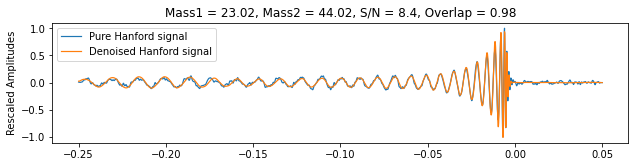

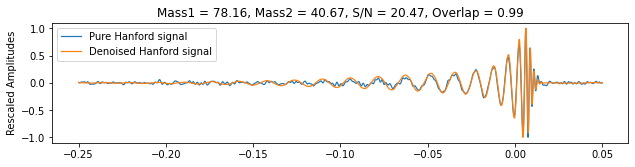

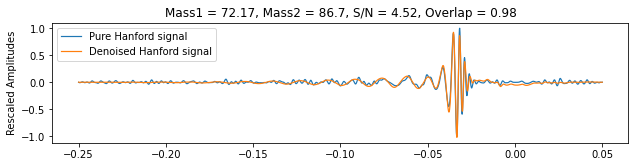

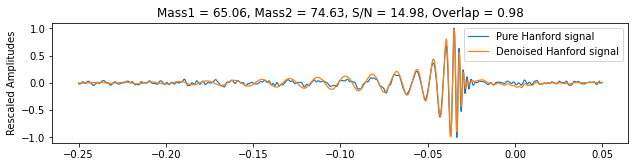

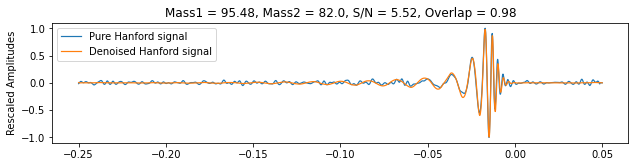

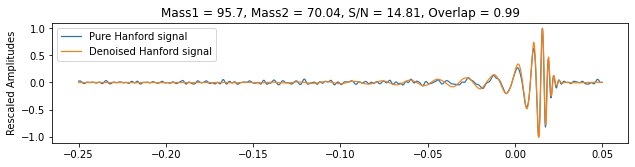

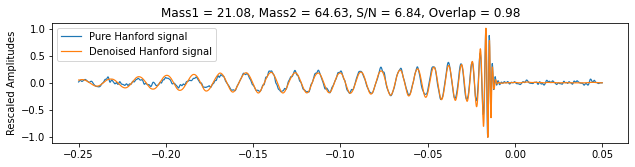

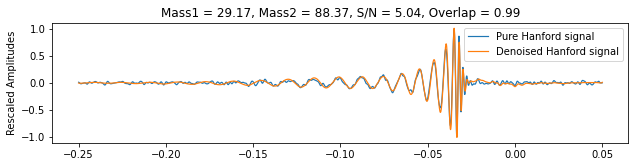

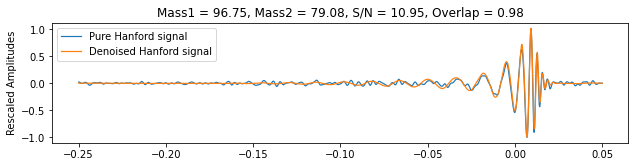

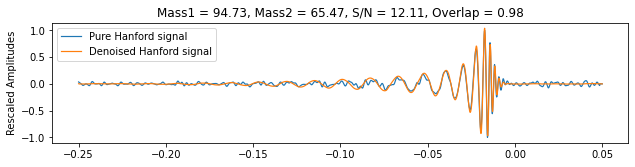

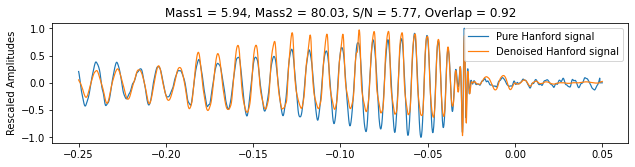

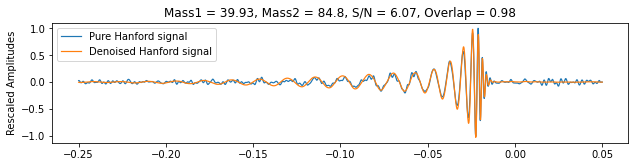

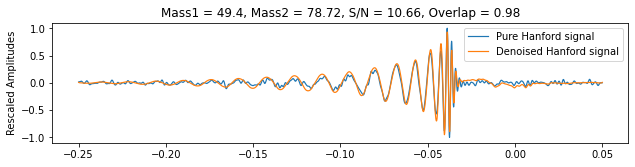

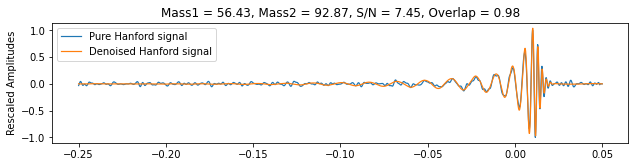

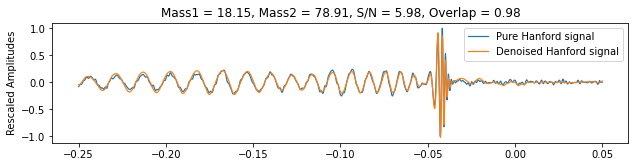

In [4]:
f1 = h5py.File('/fred/oz016/Chayan/GW-Denoiser/evaluation/results_IMBH_precessing_10_timesteps.hdf', 'r')
f2 = h5py.File("/fred/oz016/Chayan/BBH_sample_files/default_IMBH_test_precession.hdf", "r")
    
for i in range(25):
    decoded_signals = f1['denoised_signals'][i].astype(np.float64)
    pure_signals = f1['pure_signals'][i].astype(np.float64)

    m1 = f2['injection_parameters']['mass1'][i]
    m2 = f2['injection_parameters']['mass2'][i]
    snr = f2['injection_parameters']['l1_snr'][i]*f2['injection_parameters']['scale_factor'][i]

    plot_reconstructed(decoded_signals, pure_signals, m1, m2, snr)
    

<ipython-input-100-6376e1ff364b>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,5))


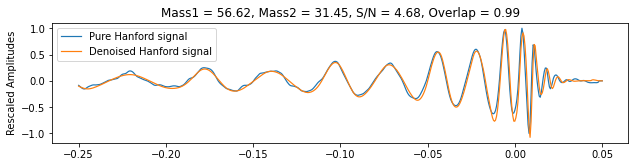

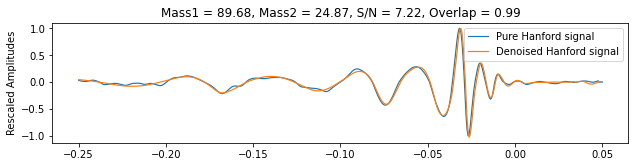

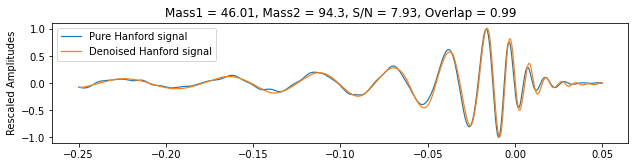

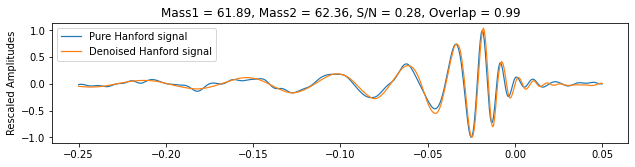

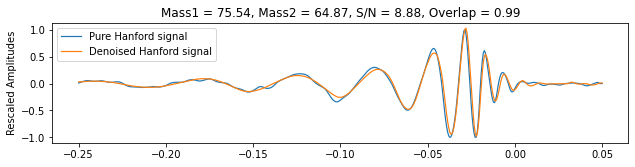

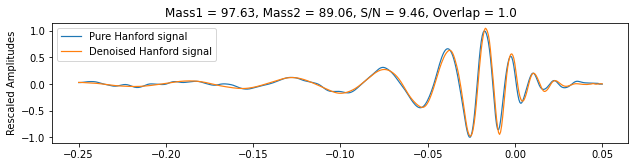

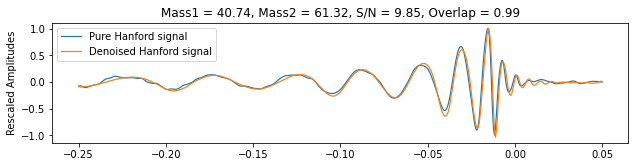

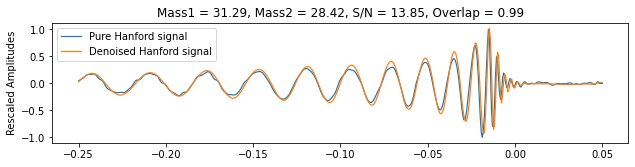

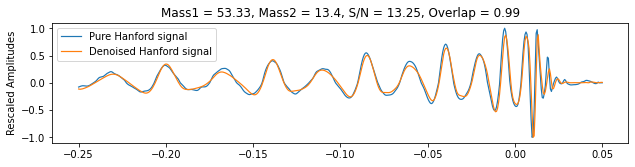

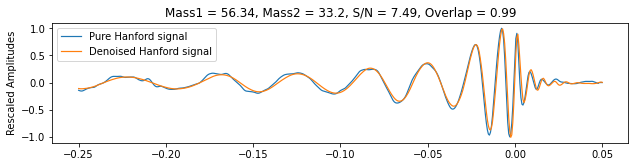

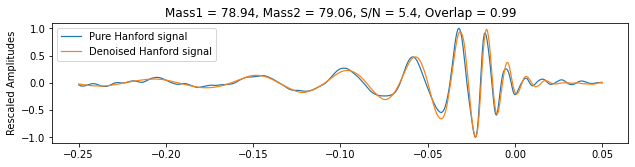

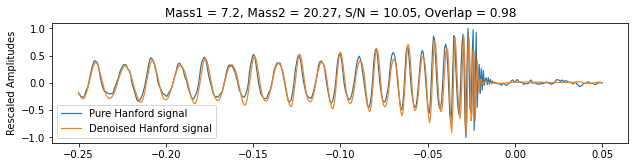

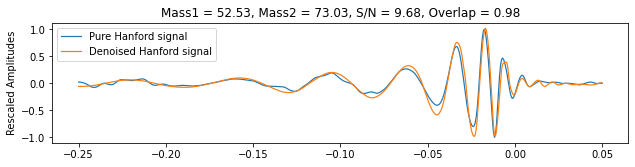

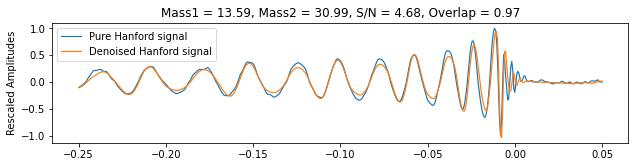

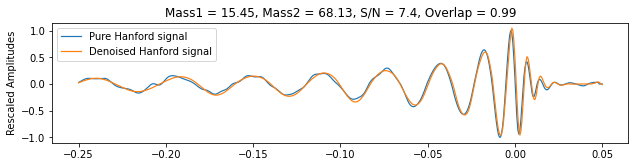

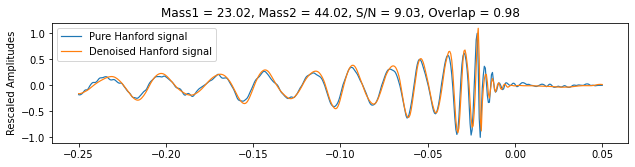

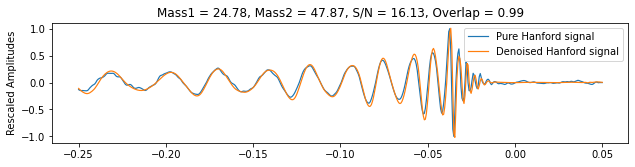

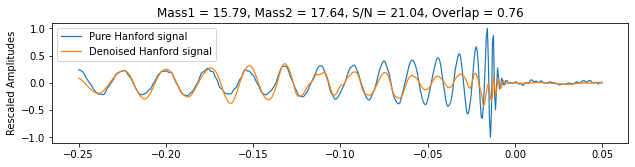

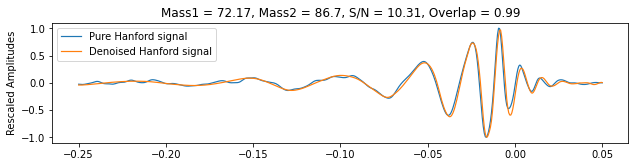

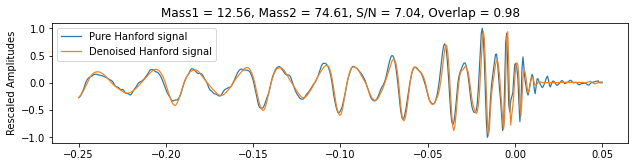

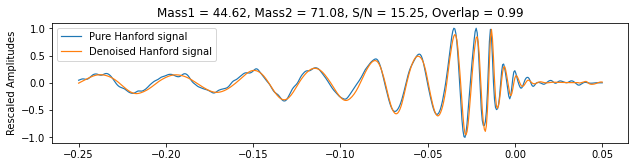

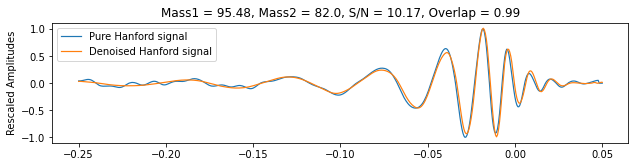

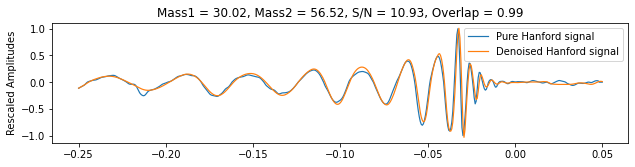

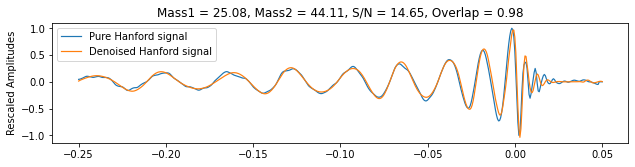

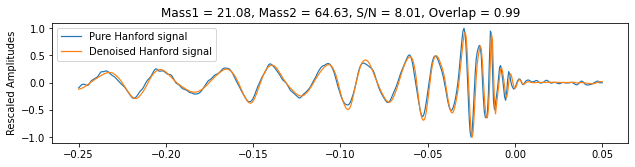

In [102]:
f1 = h5py.File('/fred/oz016/Chayan/GW-Denoiser/evaluation/results_IMBH_whitened_waveforms.hdf', 'r')
f2 = h5py.File("/fred/oz016/Chayan/BBH_sample_files/default_IMBH_test_new.hdf", "r")
    
for i in range(25):
    decoded_signals = f1['denoised_signals'][i].astype(np.float64)
    pure_signals = f1['pure_signals'][i].astype(np.float64)

    m1 = f2['injection_parameters']['mass1'][i]
    m2 = f2['injection_parameters']['mass2'][i]
    snr = f2['injection_parameters']['l1_snr'][i]*f2['injection_parameters']['scale_factor'][i]

    plot_reconstructed(decoded_signals, pure_signals, m1, m2, snr)
    

<ipython-input-5-e6f2a58f37ad>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,5))


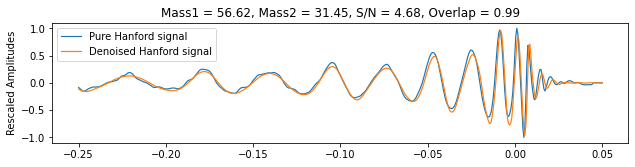

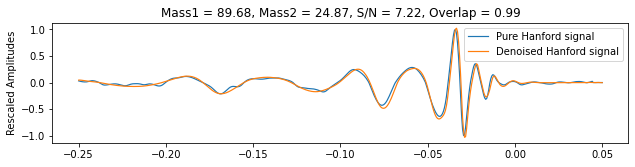

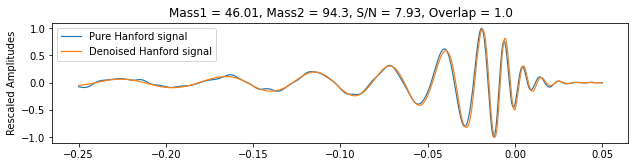

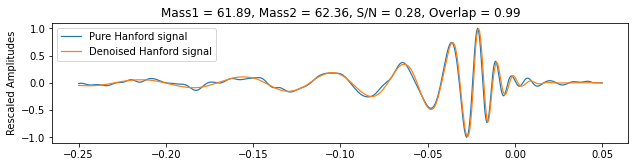

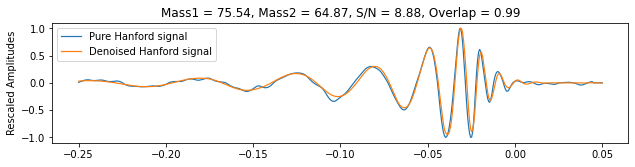

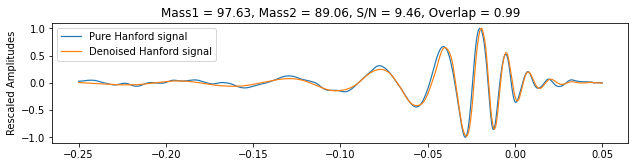

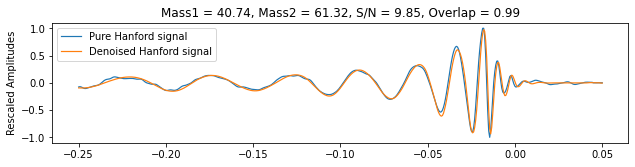

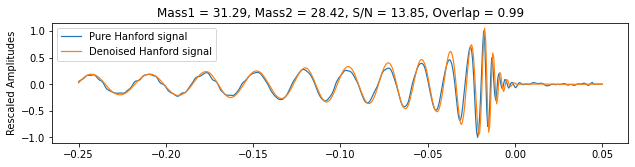

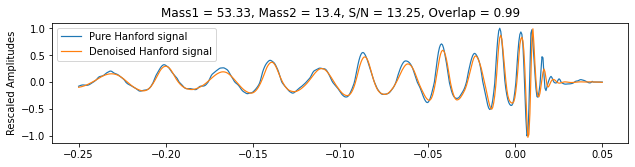

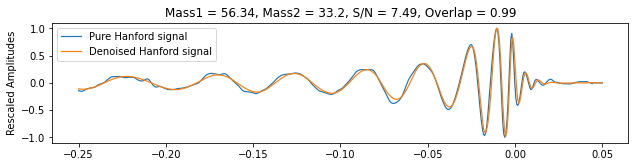

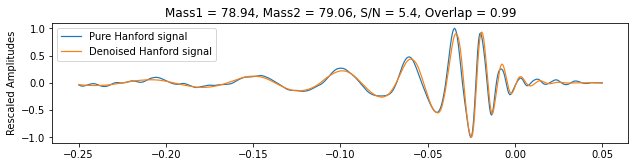

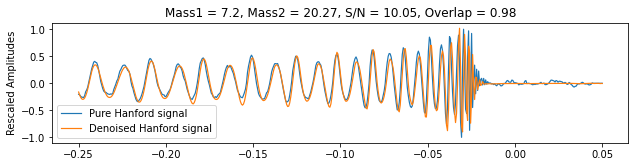

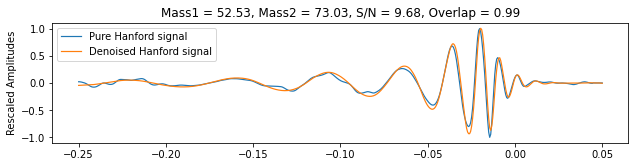

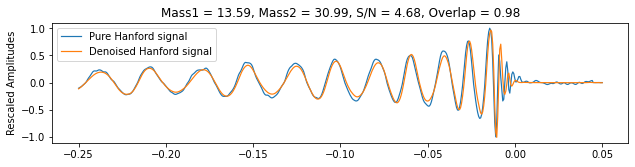

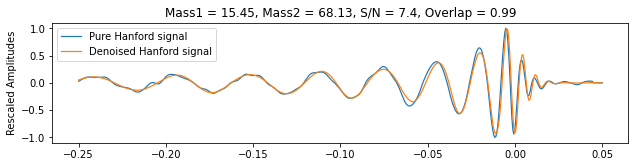

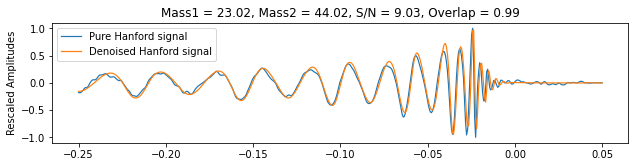

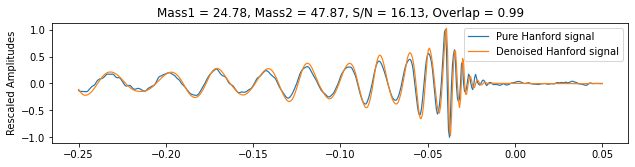

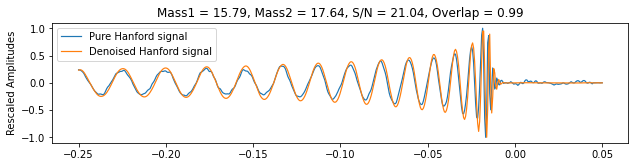

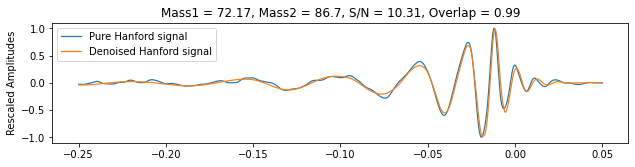

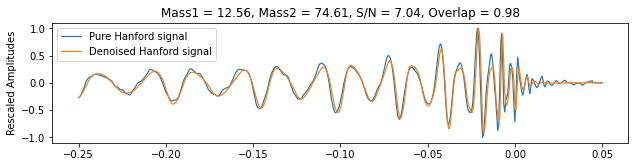

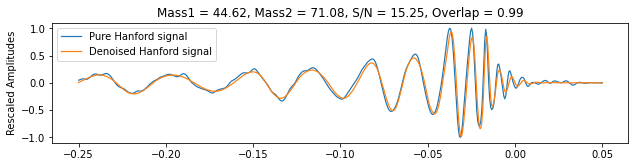

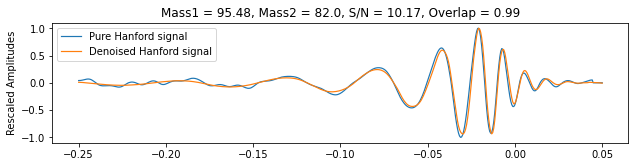

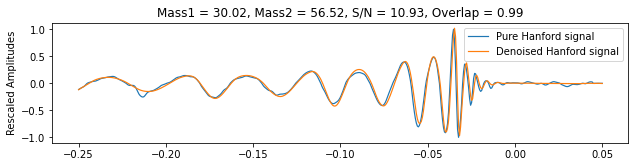

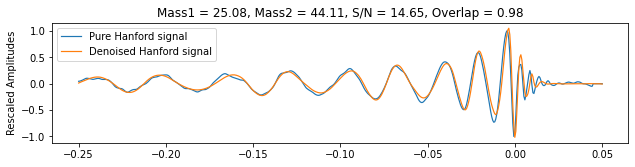

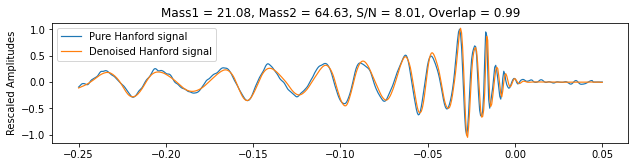

In [6]:
f1 = h5py.File('/fred/oz016/Chayan/GW-Denoiser/evaluation/results_IMBH_whitened_waveforms_10_timesteps.hdf', 'r')
f2 = h5py.File("/fred/oz016/Chayan/BBH_sample_files/default_IMBH_test_new.hdf", "r")
    
for i in range(25):
    decoded_signals = f1['denoised_signals'][i].astype(np.float64)
    pure_signals = f1['pure_signals'][i].astype(np.float64)

    m1 = f2['injection_parameters']['mass1'][i]
    m2 = f2['injection_parameters']['mass2'][i]
    snr = f2['injection_parameters']['l1_snr'][i]*f2['injection_parameters']['scale_factor'][i]

    plot_reconstructed(decoded_signals, pure_signals, m1, m2, snr)
    